# TESTES DE HIPÓTESES SOBRE UMA MÉDIA POPULACIONAL(µ)

# Teste Z para a média populacional (amostra aleatória)

Este teste verifica se a média de uma população ($\mu$) assume um valor específico ($\mu_0$) a partir de uma amostra aleatória. É apropriado quando:

- A população é (aproximadamente) normal OU a amostra é grande ($n>30$, pelo Teorema do Limite Central);
- O desvio-padrão populacional é conhecido ($\sigma$ conhecido).

> Se $\sigma$ for desconhecido e $n$ for pequeno, use o teste t de Student em vez do teste Z.

## Hipóteses
- Teste bilateral:  
  $H_0: \mu = \mu_0$  
  $H_1: \mu \neq \mu_0$

- Teste unilateral à direita:  
  $H_0: \mu \le \mu_0$  
  $H_1: \mu > \mu_0$

- Teste unilateral à esquerda:  
  $H_0: \mu \ge \mu_0$  
  $H_1: \mu < \mu_0$

## Estatística de teste
Padronize a média amostral $\bar X$ para compará-la com a distribuição normal padrão:

$$
Z_{calc} = \frac{\bar X - \mu_0}{\sigma_{\bar X}} \sim \mathcal N(0,1), \quad \text{onde} \quad \sigma_{\bar X} = \frac{\sigma}{\sqrt{n}}
$$

## Regra de decisão (região crítica)
Seja $\alpha$ o nível de significância:
- Bilateral: rejeite $H_0$ se $|Z_{calc}| > z_{\alpha/2}$.
- Unilateral à direita: rejeite $H_0$ se $Z_{calc} > z_{\alpha}$.
- Unilateral à esquerda: rejeite $H_0$ se $Z_{calc} < -z_{\alpha}$.

## p-valor
- Bilateral: $p = 2\,P\big(Z \ge |Z_{calc}|\big)$.
- Unilateral à direita: $p = P\big(Z \ge Z_{calc}\big)$.
- Unilateral à esquerda: $p = P\big(Z \le Z_{calc}\big)$.

Rejeite $H_0$ se $p \le \alpha$; caso contrário, não rejeite $H_0$.

## Função Teste Z para uma amostra

In [1]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import norm
import pandas as pd
import scipy.stats as stats

In [10]:
def teste_z_uma_amostra(
    x=None,              # dados brutos da amostra (iterável)
    n=None,              # tamanho da amostra, se não houver x
    xbar=None,           # média amostral, se não houver x
    sigma=None,          # desvio-padrão populacional (conhecido, > 0)
    mu0=0.0,             # valor hipotético de média sob H0
    alpha=0.05,          # nível de significância
    alternativa="bilateral"  # 'bilateral' | 'esquerda' | 'direita'
):
    alternativa = str(alternativa).lower()
    assert alternativa in ("bilateral", "esquerda", "direita"), "alternativa inválida"

    # Definição de n e xbar
    if x is not None:
        arr = np.asarray(list(x), dtype=float)
        n = int(arr.size)
        assert n > 0, "Amostra vazia."
        xbar = float(arr.mean())
    else:
        assert (n is not None) and (xbar is not None), "Forneça x ou (n e xbar)."
        n = int(n)
        xbar = float(xbar)
        assert n > 0, "n deve ser positivo."

    # Checagens
    assert sigma is not None and sigma > 0, "sigma (populacional) deve ser > 0"
    sigma = float(sigma)

    # Erro-padrão e estatística Z
    se = sigma / math.sqrt(n)
    Z_calc = (xbar - mu0) / se

    # p-valor conforme alternativa
    if alternativa == "bilateral":
        p_valor = 2.0 * min(stats.norm.cdf(Z_calc), 1.0 - stats.norm.cdf(Z_calc))
        z_c = stats.norm.ppf(1 - alpha/2)
        z_crit_esq, z_crit_dir = -z_c, z_c
        rejeita = (abs(Z_calc) > z_c) or (p_valor <= alpha)
    elif alternativa == "esquerda":
        p_valor = stats.norm.cdf(Z_calc)  # P(Z ≤ Z_calc)
        z_crit_esq = stats.norm.ppf(alpha)  # z_{α}
        z_crit_dir = None
        rejeita = (Z_calc < z_crit_esq) or (p_valor <= alpha)
    else:  # "direita"
        p_valor = 1.0 - stats.norm.cdf(Z_calc)  # P(Z ≥ Z_calc)
        z_crit_dir = stats.norm.ppf(1 - alpha)  # z_{1-α}
        z_crit_esq = None
        rejeita = (Z_calc > z_crit_dir) or (p_valor <= alpha)

    decisao = "Rejeitar" if rejeita else "Não rejeitar"

    return {
        "n": n,
        "xbar": xbar,
        "sigma": sigma,
        "mu0": mu0,
        "se": se,
        "Z_calc": float(Z_calc),
        "p_valor": float(p_valor),
        "alpha": float(alpha),
        "alternativa": alternativa,
        "z_crit_esq": None if z_crit_esq is None else float(z_crit_esq),
        "z_crit_dir": None if z_crit_dir is None else float(z_crit_dir),
        "decisao": decisao,
    }

## Função de plotagem Teste Z

In [11]:
def plot_normal_z_test(Z_calc, alpha=0.05, alternativa="bilateral", titulo="Distribuição Normal Padrão - Teste Z"):
    alternativa = str(alternativa).lower()
    assert alternativa in ("bilateral", "esquerda", "direita"), "alternativa inválida"

    x = np.linspace(-4.5, 4.5, 1600)
    y = stats.norm.pdf(x)

    plt.figure(figsize=(9, 5))
    plt.plot(x, y, color="black", lw=1.8, label="N(0,1)")

    # Regiões críticas
    if alternativa == "bilateral":
        z_c = stats.norm.ppf(1 - alpha/2)
        mask_left_c = x <= -z_c
        mask_right_c = x >= z_c
        plt.fill_between(x[mask_left_c], 0, y[mask_left_c], color="tab:red", alpha=0.25, label=f"Regiões críticas (α={alpha:.2%})")
        plt.fill_between(x[mask_right_c], 0, y[mask_right_c], color="tab:red", alpha=0.25)
        plt.axvline(-z_c, color="tab:red", ls="--", lw=2, label=f"± z_c = {z_c:.3f}")
        plt.axvline(z_c, color="tab:red", ls="--", lw=2)

        # p-valor (bicaudal)
        z_abs = abs(Z_calc)
        mask_left_p = x <= -z_abs
        mask_right_p = x >= z_abs
        p_valor = 2 * (1 - stats.norm.cdf(z_abs))
        plt.fill_between(x[mask_left_p], 0, y[mask_left_p], color="tab:blue", alpha=0.35, label=f"p-valor = {p_valor:.4f}")
        plt.fill_between(x[mask_right_p], 0, y[mask_right_p], color="tab:blue", alpha=0.35)

    elif alternativa == "esquerda":
        z_c_esq = stats.norm.ppf(alpha)
        mask_alpha = x <= z_c_esq
        plt.fill_between(x[mask_alpha], 0, y[mask_alpha], color="tab:red", alpha=0.25, label=f"Região crítica (α={alpha:.2%})")
        plt.axvline(z_c_esq, color="tab:red", ls="--", lw=2, label=f"z_c = {z_c_esq:.3f}")

        # p-valor (cauda esquerda)
        mask_p = x <= Z_calc
        p_valor = stats.norm.cdf(Z_calc)
        plt.fill_between(x[mask_p], 0, y[mask_p], color="tab:blue", alpha=0.35, label=f"p-valor = {p_valor:.4f}")

    else:  # "direita"
        z_c_dir = stats.norm.ppf(1 - alpha)
        mask_alpha = x >= z_c_dir
        plt.fill_between(x[mask_alpha], 0, y[mask_alpha], color="tab:red", alpha=0.25, label=f"Região crítica (α={alpha:.2%})")
        plt.axvline(z_c_dir, color="tab:red", ls="--", lw=2, label=f"z_c = {z_c_dir:.3f}")

        # p-valor (cauda direita)
        mask_p = x >= Z_calc
        p_valor = 1 - stats.norm.cdf(Z_calc)
        plt.fill_between(x[mask_p], 0, y[mask_p], color="tab:blue", alpha=0.35, label=f"p-valor = {p_valor:.4f}")

    # Linha do Z_calc
    plt.axvline(Z_calc, color="tab:blue", ls="-", lw=2, label=f"Z_calc = {Z_calc:.3f}")

    plt.title(titulo)
    plt.xlabel("z")
    plt.ylabel("densidade")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Teste Z para uma amostra
### (Exemplo 8 do Material)

Contexto: o fabricante afirma μ ≥ 4,2 g (σ conhecido = 1 g).  
A amostra (n = 42) apresentou média x̄ = 3,9 g. Nível de significância α = 5%.

Hipóteses (unilateral à esquerda):
- H0: μ = 4,2
- H1: μ < 4,2

Regra: rejeitar H0 se z_calc < z_{α} ou se p-valor < α.

In [12]:
# Exemplo 8 - Cálculo do teste Z (unilateral à esquerda)
alpha = 0.05
mu0 = 4.2
sigma = 1.0
n = 42
xbar = 3.9

# Usa a função nova de teste Z para uma amostra
res8 = teste_z_uma_amostra(n=n, xbar=xbar, sigma=sigma, mu0=mu0, alpha=alpha, alternativa="esquerda")

# Impressão organizada dos resultados
print(
    f"n = {res8['n']}, xbar = {res8['xbar']:.3f}, σ = {res8['sigma']:.3f}, μ0 = {res8['mu0']:.3f}\n"
    f"SE = {res8['se']:.4f}, Z_calc = {res8['Z_calc']:.4f}, z_c = {res8['z_crit_esq']:.4f}, p-valor = {res8['p_valor']:.4f}\n"
    f"Decisão: {res8['decisao']} (α = {res8['alpha']:.2%}, alternativa = {res8['alternativa']})"
)

# Variáveis para o gráfico
Z_calc_8 = float(res8['Z_calc'])
alpha_8 = float(res8['alpha'])
alt_8 = res8['alternativa']

n = 42, xbar = 3.900, σ = 1.000, μ0 = 4.200
SE = 0.1543, Z_calc = -1.9442, z_c = -1.6449, p-valor = 0.0259
Decisão: Rejeitar (α = 5.00%, alternativa = esquerda)


## Plotagem do gráfico

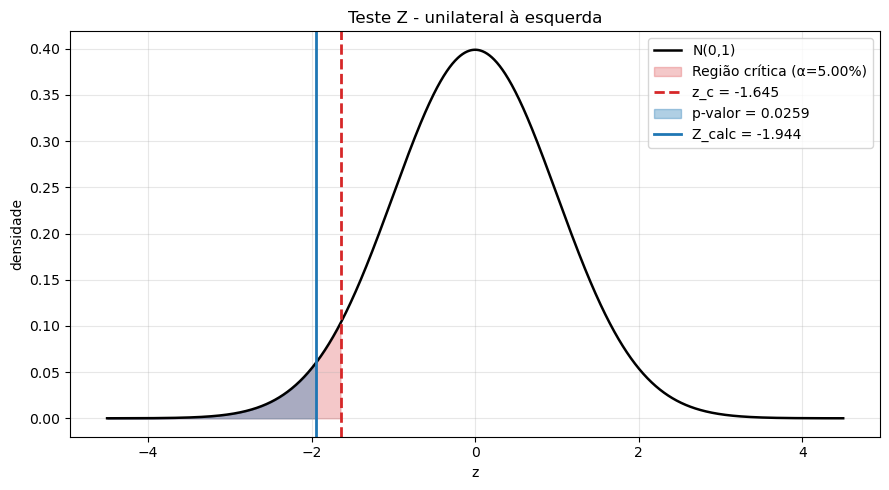

In [5]:
plot_normal_z_test(Z_calc_8, alpha=alpha_8, alternativa=alt_8, titulo="Teste Z - unilateral à esquerda")

## Teste Z com Scipy

In [13]:
alpha = 0.05
mu0 = 4.2
sigma = 1.0
n = 42
xbar = 3.9

# Cálculos com SciPy
se = sigma / math.sqrt(n)
Z_calc = (xbar - mu0) / se
z_crit_esq = stats.norm.ppf(alpha)
p_valor = stats.norm.cdf(Z_calc)

decisao_scipy = "Rejeitar" if (Z_calc < z_crit_esq) or (p_valor <= alpha) else "Não rejeitar"

print(
    f"n = {n}, xbar = {xbar:.3f}, σ = {sigma:.3f}, μ0 = {mu0:.3f}\n"
    f"SE = {se:.4f}, Z_calc = {Z_calc:.4f}, z_c = {z_crit_esq:.4f}, p-valor = {p_valor:.4f}\n"
    f"Decisão: {decisao_scipy} (α = {alpha:.2%}, alternativa = 'esquerda')"
)

n = 42, xbar = 3.900, σ = 1.000, μ0 = 4.200
SE = 0.1543, Z_calc = -1.9442, z_c = -1.6449, p-valor = 0.0259
Decisão: Rejeitar (α = 5.00%, alternativa = 'esquerda')


# Comparação Manual × SciPy (rever em casa para remover o comeco)

Origem  Z_calc  p_valor  z_crit_esq Decisão 
Manual -1.9442  0.0259    -1.6449   Rejeitar
 SciPy -1.9442  0.0259    -1.6449   Rejeitar


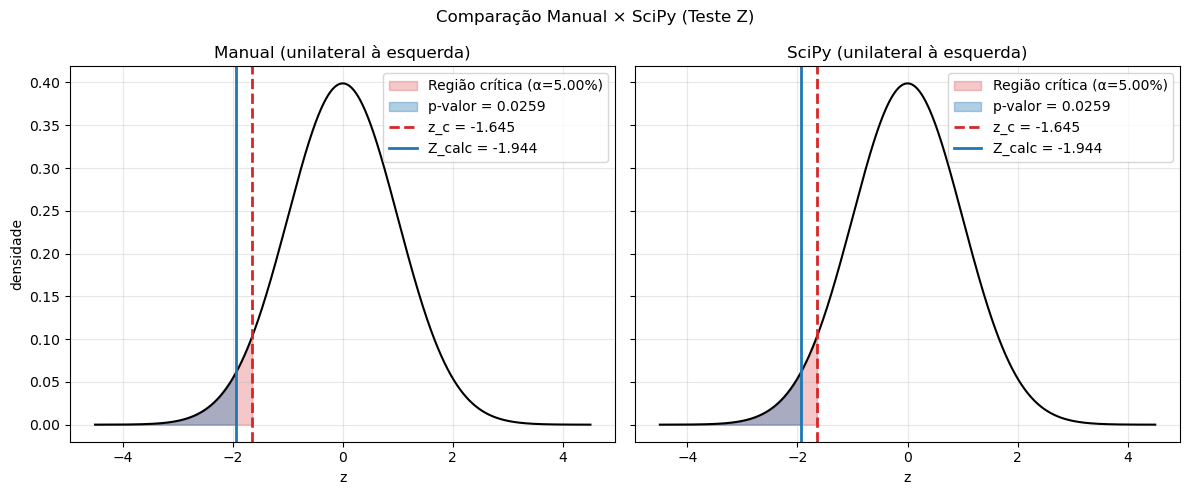

In [19]:
try:
    # Dados do manual
    Z_m = float(res8["Z_calc"])
    p_m = float(res8["p_valor"])
    zcrit_m = float(res8["z_crit_esq"])
    dec_m = res8["decisao"]
    alpha_m = float(res8["alpha"])

    # Dados do Scipy
    Z_s = float(Z_calc)
    p_s = float(p_valor)
    zcrit_s = float(z_crit_esq)
    dec_s = decisao_scipy

    # Tabela comparativa
    comp8 = pd.DataFrame({
        "Origem": ["Manual", "SciPy"],
        "Z_calc": [Z_m, Z_s],
        "p_valor": [p_m, p_s],
        "z_crit_esq": [zcrit_m, zcrit_s],
        "Decisão": [dec_m, dec_s],
    })
    print(comp8.to_string(index=False, justify='center', float_format=lambda v: f"{v:.4f}"))

    # Gráfico comparativo lado a lado
    x = np.linspace(-4.5, 4.5, 1600)
    y = stats.norm.pdf(x)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Manual
    mask_c_m = x <= zcrit_m
    mask_p_m = x <= Z_m
    ax[0].plot(x, y, color='black', lw=1.5)
    ax[0].fill_between(x[mask_c_m], 0, y[mask_c_m], color='tab:red', alpha=0.25,
                       label=f"Região crítica (α={alpha_m:.2%})")
    ax[0].fill_between(x[mask_p_m], 0, y[mask_p_m], color='tab:blue', alpha=0.35,
                       label=f"p-valor = {p_m:.4f}")
    ax[0].axvline(zcrit_m, color='tab:red', ls='--', lw=2, label=f"z_c = {zcrit_m:.3f}")
    ax[0].axvline(Z_m, color='tab:blue', lw=2, label=f"Z_calc = {Z_m:.3f}")
    ax[0].set_title('Manual (unilateral à esquerda)')
    ax[0].set_xlabel('z')
    ax[0].set_ylabel('densidade')
    ax[0].grid(alpha=0.3)
    ax[0].legend(loc='upper right')

    # SciPy
    mask_c_s = x <= zcrit_s
    mask_p_s = x <= Z_s
    ax[1].plot(x, y, color='black', lw=1.5)
    ax[1].fill_between(x[mask_c_s], 0, y[mask_c_s], color='tab:red', alpha=0.25,
                       label=f"Região crítica (α={alpha_m:.2%})")
    ax[1].fill_between(x[mask_p_s], 0, y[mask_p_s], color='tab:blue', alpha=0.35,
                       label=f"p-valor = {p_s:.4f}")
    ax[1].axvline(zcrit_s, color='tab:red', ls='--', lw=2, label=f"z_c = {zcrit_s:.3f}")
    ax[1].axvline(Z_s, color='tab:blue', lw=2, label=f"Z_calc = {Z_s:.3f}")
    ax[1].set_title("SciPy (unilateral à esquerda)")
    ax[1].set_xlabel('z')
    ax[1].grid(alpha=0.3)
    ax[1].legend(loc='upper right')

    fig.suptitle('Comparação Manual × SciPy (Teste Z)')
    plt.tight_layout()
    plt.show()
except NameError:
    print("Variáveis não definidas.")

## Teste t de Student (uma amostra)

Uso: quando o desvio-padrão populacional (σ) é desconhecido. Nessa situação, σ é estimado pelo desvio-padrão amostral S e a estatística de teste passa a seguir a distribuição t de Student com n − 1 graus de liberdade. É apropriado quando a população é aproximadamente normal ou quando a amostra não é grande o suficiente para invocar o TLC com segurança.

Hipóteses típicas
- Teste bilateral:
  - H0: μ = μ0
  - H1: μ ≠ μ0
- Teste unilateral à direita:
  - H0: μ ≤ μ0
  - H1: μ > μ0
- Teste unilateral à esquerda:
  - H0: μ ≥ μ0
  - H1: μ < μ0

Estatística de teste
A média amostral X̄ é padronizada usando S/√n em vez de σ/√n:

$$
T_{calc} = \frac{\bar X - \mu_0}{S/\sqrt{n}} \;\sim\; t_{\,n-1}
$$

Regra de decisão (regiões críticas)

Seja α = significância e t_{α,ν} = quantil da t de Student com ν = n−1 gl.
- Bilateral: rejeitar H0 se |T_calc| > t_{α/2,\,n-1}.
- Unilateral à direita: rejeitar H0 se T_calc > t_{α,\,n-1}.
- Unilateral à esquerda: rejeitar H0 se T_calc < −t_{α,\,n-1}.

p-valor
Considere T ∼ t_{n−1}:
- Bilateral: p = 2·P(T ≥ |T_calc|).
- Direita: p = P(T ≥ T_calc).
- Esquerda: p = P(T ≤ T_calc).
Decida por p-valor: rejeite H0 se p ≤ α; caso contrário, não rejeite.

### Função Manual

In [20]:
def teste_t_uma_amostra_manual(
    x=None,                 # dados brutos (iterável)
    n=None,                 # tamanho da amostra, se não houver x
    xbar=None,              # média amostral, se não houver x
    s=None,                 # desvio-padrão amostral (> 0)
    mu0=0.0,                # média hipotética sob H0
    alpha=0.05,             # nível de significância
    alternativa="bilateral" # 'bilateral' | 'esquerda' | 'direita'
):
    alternativa = str(alternativa).lower()
    assert alternativa in ("bilateral", "esquerda", "direita"), "alternativa inválida"

    # Determinação de n, xbar e s quando x é fornecido
    if x is not None:
        arr = np.asarray(list(x), dtype=float)
        n = int(arr.size)
        assert n > 1, "É necessário n > 1 para calcular o desvio-padrão amostral."
        xbar = float(arr.mean())
        s = float(arr.std(ddof=1))
    else:
        # Resumo (n, xbar, s) obrigatórios
        assert (n is not None) and (xbar is not None) and (s is not None), "Forneça x ou (n, xbar, s)."
        n = int(n)
        xbar = float(xbar)
        s = float(s)
        assert n > 1, "n deve ser > 1"
        assert s > 0, "s (desvio-padrão amostral) deve ser > 0"

    gl = n - 1
    se = s / math.sqrt(n)
    T_calc = (xbar - mu0) / se

    # p-valor e valores críticos conforme alternativa
    if alternativa == "bilateral":
        p_valor = 2.0 * min(stats.t.cdf(T_calc, df=gl), 1.0 - stats.t.cdf(T_calc, df=gl))
        t_c = stats.t.ppf(1 - alpha/2, df=gl)
        t_crit_esq, t_crit_dir = -t_c, t_c
        rejeita = (abs(T_calc) > t_c) or (p_valor <= alpha)
    elif alternativa == "esquerda":
        p_valor = stats.t.cdf(T_calc, df=gl)            # P(T ≤ T_calc)
        t_crit_esq = stats.t.ppf(alpha, df=gl)         # t_{α,gl}
        t_crit_dir = None
        rejeita = (T_calc < t_crit_esq) or (p_valor <= alpha)
    else:  # "direita"
        p_valor = 1.0 - stats.t.cdf(T_calc, df=gl)     # P(T ≥ T_calc)
        t_crit_dir = stats.t.ppf(1 - alpha, df=gl)     # t_{1-α,gl}
        t_crit_esq = None
        rejeita = (T_calc > t_crit_dir) or (p_valor <= alpha)

    decisao = "Rejeitar" if rejeita else "Não rejeitar"

    return {
        "n": n,
        "xbar": xbar,
        "s": s,
        "se": se,
        "gl": int(gl),
        "T_calc": float(T_calc),
        "p_valor": float(p_valor),
        "alpha": float(alpha),
        "alternativa": alternativa,
        "t_crit_esq": None if t_crit_esq is None else float(t_crit_esq),
        "t_crit_dir": None if t_crit_dir is None else float(t_crit_dir),
        "decisao": decisao,
    }

### (Exemplo 9 do Material)

Problema: Antes, o tempo médio era μ0 = 18 min. Após mudanças, coletou-se uma amostra (n = 25) com média xbar = 16,808 min e desvio-padrão s = 2,733 min.  
Objetivo: Verificar, ao nível de significância α = 1%, se há evidência de melhoria (redução do tempo médio).

### Dados

Hipóteses (teste unilateral à esquerda):
- H0: μ = 18
- H1: μ < 18

- s = 2,733 min
- xbar = 16,808

### Teste Manual

In [21]:
# Parâmetros do Exemplo 9 (unilateral à esquerda)
alpha_9 = 0.01
mu0_9 = 18.0
n_9 = 25
xbar_9 = 16.808
s_9 = 2.733

# Teste manual usando a função criada
res9 = teste_t_uma_amostra_manual(n=n_9, xbar=xbar_9, s=s_9, mu0=mu0_9, alpha=alpha_9, alternativa="esquerda")

print(
    f"n = {res9['n']}, xbar = {res9['xbar']:.3f}, s = {res9['s']:.3f}, μ0 = {mu0_9:.3f}\n"
    f"SE = {res9['se']:.4f}, gl = {res9['gl']}, T_calc = {res9['T_calc']:.4f}, t_c = {res9['t_crit_esq']:.4f}, p-valor = {res9['p_valor']:.6f}\n"
    f"Decisão: {res9['decisao']} (α = {res9['alpha']:.2%}, alternativa = {res9['alternativa']})"
)

# Conclusão contextual
if res9['decisao'].startswith('Rejeitar'):
    conclusao_9 = (
        "Há evidências, ao nível de 1%, de que a média reduziu em relação a 18 min (melhoria)."
    )
else:
    conclusao_9 = (
        "Não há evidências suficientes, ao nível de 1%, de que a média seja menor que 18 min (sem comprovar melhoria)."
    )
print("Conclusão:", conclusao_9)

# Variáveis para plotagem
T_calc_9 = float(res9['T_calc'])
gl_9 = int(res9['gl'])

n = 25, xbar = 16.808, s = 2.733, μ0 = 18.000
SE = 0.5466, gl = 24, T_calc = -2.1808, t_c = -2.4922, p-valor = 0.019617
Decisão: Não rejeitar (α = 1.00%, alternativa = esquerda)
Conclusão: Não há evidências suficientes, ao nível de 1%, de que a média seja menor que 18 min (sem comprovar melhoria).


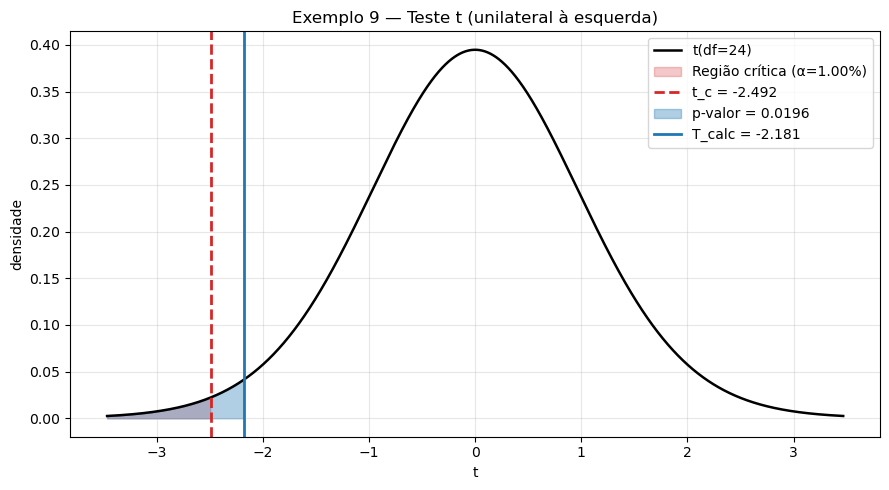

In [22]:
x = np.linspace(stats.t.ppf(0.001, gl_9), stats.t.ppf(0.999, gl_9), 1600)
y = stats.t.pdf(x, df=gl_9)

t_c_esq = float(res9['t_crit_esq'])
p_valor_9 = float(res9['p_valor'])

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x, y, color='black', lw=1.8, label=f"t(df={gl_9})")

# Região crítica (α na cauda esquerda)
mask_crit = x <= t_c_esq
ax.fill_between(x[mask_crit], 0, y[mask_crit], color='tab:red', alpha=0.25,
                label=f"Região crítica (α={alpha_9:.2%})")
ax.axvline(t_c_esq, color='tab:red', ls='--', lw=2, label=f"t_c = {t_c_esq:.3f}")

# p-valor (área até T_calc na cauda esquerda)
mask_p = x <= T_calc_9
ax.fill_between(x[mask_p], 0, y[mask_p], color='tab:blue', alpha=0.35,
                label=f"p-valor = {p_valor_9:.4f}")
ax.axvline(T_calc_9, color='tab:blue', lw=2, label=f"T_calc = {T_calc_9:.3f}")

ax.set_title('Exemplo 9 — Teste t (unilateral à esquerda)')
ax.set_xlabel('t')
ax.set_ylabel('densidade')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Teste t com Scipy

In [30]:
se_9 = s_9 / math.sqrt(n_9)
T_scipy_9 = (xbar_9 - mu0_9) / se_9
p_scipy_9 = stats.t.cdf(T_scipy_9, df=n_9 - 1)
tcrit_esq_9 = stats.t.ppf(alpha_9, df=n_9 - 1)

decisao_scipy_9 = "Rejeitar" if (T_scipy_9 < tcrit_esq_9) or (p_scipy_9 <= alpha_9) else "Não rejeitar"

print(
    f"n = {n_9}, xbar = {xbar_9:.3f}, s = {s_9:.3f}, μ0 = {mu0_9:.3f}\n"
    f"SE = {se_9:.4f}, gl = {n_9-1}, T_calc = {T_scipy_9:.4f}, t_c = {tcrit_esq_9:.4f}, p-valor = {p_scipy_9:.6f}\n"
    f"Decisão: {decisao_scipy_9} (α = {alpha_9:.2%}, alternativa = 'esquerda')"
)

n = 25, xbar = 16.808, s = 2.733, μ0 = 18.000
SE = 0.5466, gl = 24, T_calc = -2.1808, t_c = -2.4922, p-valor = 0.019617
Decisão: Não rejeitar (α = 1.00%, alternativa = 'esquerda')


### Comparação Manual x Scipy

Origem  T_calc  p_valor  t_crit_esq   Decisão   
Manual -2.1808  0.0196    -2.4922   Não rejeitar
 SciPy -2.1808  0.0196    -2.4922   Não rejeitar


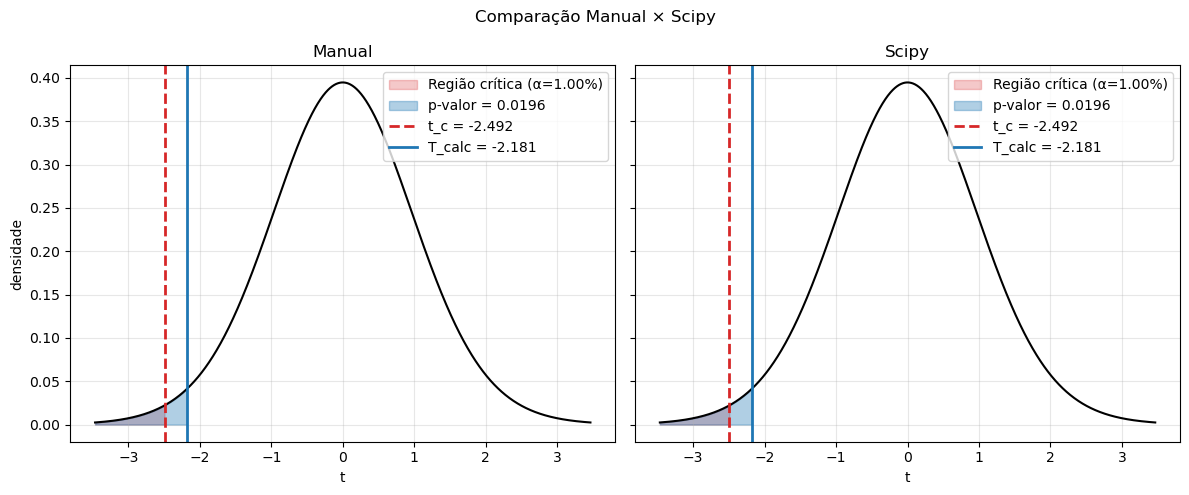

In [31]:
_comp = pd.DataFrame({
    "Origem": ["Manual", "SciPy"],
    "T_calc": [T_calc_9, T_scipy_9],
    "p_valor": [res9['p_valor'], p_scipy_9],
    "t_crit_esq": [res9['t_crit_esq'], tcrit_esq_9],
    "Decisão": [res9['decisao'], decisao_scipy_9]
})
print(_comp.to_string(index=False, justify='center', float_format=lambda v: f"{v:.4f}"))

# Gráfico comparativo lado a lado
x = np.linspace(stats.t.ppf(0.001, gl_9), stats.t.ppf(0.999, gl_9), 1200)
y = stats.t.pdf(x, gl_9)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Manual
mask_c_m = x <= res9['t_crit_esq']
mask_p_m = x <= T_calc_9
ax[0].plot(x, y, color='black', lw=1.5)
ax[0].fill_between(x[mask_c_m], 0, y[mask_c_m], color='tab:red', alpha=0.25, label=f"Região crítica (α={alpha_9:.2%})")
ax[0].fill_between(x[mask_p_m], 0, y[mask_p_m], color='tab:blue', alpha=0.35, label=f"p-valor = {res9['p_valor']:.4f}")
ax[0].axvline(res9['t_crit_esq'], color='tab:red', ls='--', lw=2, label=f"t_c = {res9['t_crit_esq']:.3f}")
ax[0].axvline(T_calc_9, color='tab:blue', lw=2, label=f"T_calc = {T_calc_9:.3f}")
ax[0].set_title('Manual')
ax[0].set_xlabel('t')
ax[0].set_ylabel('densidade')
ax[0].grid(alpha=0.3)
ax[0].legend(loc='upper right')

# SciPy
mask_c_s = x <= tcrit_esq_9
mask_p_s = x <= T_scipy_9
ax[1].plot(x, y, color='black', lw=1.5)
ax[1].fill_between(x[mask_c_s], 0, y[mask_c_s], color='tab:red', alpha=0.25, label=f"Região crítica (α={alpha_9:.2%})")
ax[1].fill_between(x[mask_p_s], 0, y[mask_p_s], color='tab:blue', alpha=0.35, label=f"p-valor = {p_scipy_9:.4f}")
ax[1].axvline(tcrit_esq_9, color='tab:red', ls='--', lw=2, label=f"t_c = {tcrit_esq_9:.3f}")
ax[1].axvline(T_scipy_9, color='tab:blue', lw=2, label=f"T_calc = {T_scipy_9:.3f}")
ax[1].set_title('Scipy')
ax[1].set_xlabel('t')
ax[1].grid(alpha=0.3)
ax[1].legend(loc='upper right')

fig.suptitle('Comparação Manual × Scipy')
plt.tight_layout()
plt.show()

## Teste t de Student para duas amostras independentes

O teste t para duas amostras independentes é usado para comparar as médias de duas populações a partir de duas amostras aleatórias e independentes, quando os desvios‑padrão populacionais são desconhecidos.

Hipóteses (forma bilateral)
- H0: μ1 = μ2
- H1: μ1 ≠ μ2

A estatística de teste T depende de como tratamos as variâncias populacionais entre os grupos:

### CASO 1 — Variâncias diferentes (σ1² ≠ σ2²)
$$
T_{calc} = \frac{\bar X_1 - \bar X_2}{\sqrt{\dfrac{S_1^2}{n_1} + \dfrac{S_2^2}{n_2}}}
$$
Graus de liberdade:
$$
\nu = \frac{\left(\dfrac{S_1^2}{n_1} + \dfrac{S_2^2}{n_2}\right)^2}{\dfrac{\left(\dfrac{S_1^2}{n_1}\right)^2}{n_1-1} + \dfrac{\left(\dfrac{S_2^2}{n_2}\right)^2}{n_2-1}}
$$

### CASO 2 — Variâncias iguais (σ1² = σ2²)
$$
S_p^2 = \frac{(n_1-1)S_1^2 + (n_2-1)S_2^2}{n_1 + n_2 - 2}
$$
Estatística de teste:
$$
T_{calc} = \frac{\bar X_1 - \bar X_2}{S_p\,\sqrt{\dfrac{1}{n_1} + \dfrac{1}{n_2}}}
$$
Graus de liberdade: $\nu = n_1 + n_2 - 2$.

Regra de decisão (nível de significância α)
rejeite H0 se $|T_{calc}| > t_{\alpha/2,\,\nu}$.

p-valor
$p = 2\,P\big(T_{\nu} \ge |T_{calc}|\big)$.

### (Exemplo 10 do Material)

Um engenheiro de qualidade suspeita que o tempo médio de fabricação de um produto plástico depende do fornecedor da matéria‑prima. Para investigar, foram coletadas duas amostras independentes de tempos de fabricação: 30 observações do Fornecedor 1 e 30 do Fornecedor 2 (ver Tabelas 7.10 e 7.11 do material).

Objetivo
- Ao nível de significância α = 5%, verificar se há diferença entre as médias dos dois fornecedores (teste bilateral).

Formulação
- H0: μ1 = μ2 (as médias são iguais)
- H1: μ1 ≠ μ2 (as médias são diferentes)

### Teste Manual

In [54]:
# Exemplo 10 — Teste t para duas amostras independentes (Manual)
# Mantém o fluxo anterior, mas adiciona um resumo de decisão independente do IC

fornecedor1 = [
    22.8, 23.4, 26.2, 24.3, 22.0, 24.8, 26.7, 25.1, 23.1, 22.8,
    25.6, 25.1, 24.3, 24.2, 22.8, 23.2, 24.7, 26.5, 24.5, 23.6,
    23.9, 22.8, 25.4, 26.7, 22.9, 23.5, 23.8, 24.6, 26.3, 22.7,
]

fornecedor2 = [
    26.8, 29.3, 28.4, 25.6, 29.4, 27.2, 27.6, 26.8, 25.4, 28.6,
    29.7, 27.2, 27.9, 28.4, 26.0, 26.8, 27.5, 28.5, 27.3, 29.1,
    29.2, 25.7, 28.4, 28.6, 27.9, 27.4, 26.7, 26.8, 25.6, 26.1,
]

x1 = np.asarray(fornecedor1, dtype=float)
x2 = np.asarray(fornecedor2, dtype=float)

alpha = 0.05

n1, n2 = x1.size, x2.size
xbar1, xbar2 = float(x1.mean()), float(x2.mean())
s1, s2 = float(x1.std(ddof=1)), float(x2.std(ddof=1))
v1, v2 = s1**2, s2**2

resumo = pd.DataFrame({
    'n': [n1, n2],
    'média': [xbar1, xbar2],
    'desvio-padrão s': [s1, s2],
    'variância s²': [v1, v2],
}, index=['Fornecedor 1', 'Fornecedor 2'])
print("Resumo descritivo:\n", resumo.round(4).to_string())

# 1) Teste de homogeneidade de variâncias — Bartlett x² (k=2)
B_stat, p_bartlett = stats.bartlett(x1, x2)
df_b = 2 - 1
chi2_crit = stats.chi2.ppf(1 - alpha, df=df_b)  # região crítica à direita
rejeita_bartlett = (B_stat > chi2_crit) or (p_bartlett <= alpha)

print("\nTeste x² de Bartlett (homogeneidade de variâncias):")
print(f"  B_calc = {B_stat:.4f}, df = {df_b}")
print(f"  x²_crit (1-α) = {chi2_crit:.4f}  -> Regra: rejeitar H0 se B_calc > x²_crit")
_msg_b = "Rejeitar H0 (variâncias diferentes)" if rejeita_bartlett else "Não rejeitar H0 (variâncias iguais)"
print(f"  p-valor = {p_bartlett:.6f}  → Decisão: {_msg_b}")

variancias_iguais = not rejeita_bartlett

# 2) Teste t para as médias (bilateral), escolhendo o caso conforme Bartlett
if variancias_iguais:
    # CASO variâncias iguais
    Sp2 = ((n1 - 1)*v1 + (n2 - 1)*v2) / (n1 + n2 - 2)
    Sp = math.sqrt(Sp2)
    se_diff = Sp * math.sqrt(1/n1 + 1/n2)
    T_calc = (xbar1 - xbar2) / se_diff
    gl = n1 + n2 - 2
    p_valor = 2 * (1 - stats.t.cdf(abs(T_calc), df=gl))
    t_crit = stats.t.ppf(1 - alpha/2, df=gl)
    metodo = "variâncias iguais (Bartlett não rejeitou H0)"
else:
    # CASO variâncias diferentes
    se_diff = math.sqrt(v1/n1 + v2/n2)
    T_calc = (xbar1 - xbar2) / se_diff
    num = (v1/n1 + v2/n2)**2
    den = (v1**2 / (n1**2 * (n1 - 1))) + (v2**2 / (n2**2 * (n2 - 1)))
    gl = num / den
    p_valor = 2 * (1 - stats.t.cdf(abs(T_calc), df=gl))
    t_crit = stats.t.ppf(1 - alpha/2, df=gl)
    metodo = "variâncias diferentes (Bartlett rejeitou H0)"

ic_low = (xbar1 - xbar2) - t_crit * se_diff
ic_high = (xbar1 - xbar2) + t_crit * se_diff

# Decisão padrão (bilateral)
rej = (p_valor <= alpha) or (abs(T_calc) > t_crit)

# Motivo detalhado
_motivos = []
_motivos.append("p-valor ≤ α" if p_valor <= alpha else "p-valor > α")
_motivos.append("|T_calc| > t_crítico" if abs(T_calc) > t_crit else "|T_calc| ≤ t_crítico")
motivo = " e ".join(_motivos)

# Interpretação
if rej:
    direcao = " (média do Fornecedor 1 > Fornecedor 2)" if (xbar1 > xbar2) else " (média do Fornecedor 1 < Fornecedor 2)"
    interpretacao = "Rejeitar H0: há evidência, no nível α, de diferença entre as médias (μ1 ≠ μ2)." + direcao
else:
    interpretacao = "Não rejeitar H0: não há evidências suficientes, no nível α, de diferença entre as médias; isso não prova que μ1 = μ2."

# Impressões completas (sempre)
print("\nTeste t para duas amostras independentes -", metodo)
print(f"  T_calc = {T_calc:.4f}")
print(f"  gl = {gl:.3f}")
print(f"  p-valor = {p_valor:.6f}")
print(f"  t_crítico (±) = {t_crit:.4f}  (α/2 = {alpha/2:.3f})")

print("\nResumo da decisão:")
print(f"  H0: μ1 = μ2  |  α = {alpha:.2%}")
print(f"  Decisão: {'Rejeitar H0' if rej else 'Não rejeitar H0'}")
print(f"  Motivo: {motivo}")
print(f"  Interpretação: {interpretacao}")

Resumo descritivo:
                n    média  desvio-padrão s  variância s²
Fornecedor 1  30  24.2767           1.3454        1.8101
Fornecedor 2  30  27.5300           1.2485        1.5587

Teste x² de Bartlett (homogeneidade de variâncias):
  B_calc = 0.1592, df = 1
  x²_crit (1-α) = 3.8415  -> Regra: rejeitar H0 se B_calc > x²_crit
  p-valor = 0.689888  → Decisão: Não rejeitar H0 (variâncias iguais)

Teste t para duas amostras independentes - variâncias iguais (Bartlett não rejeitou H0)
  T_calc = -9.7084
  gl = 58.000
  p-valor = 0.000000
  t_crítico (±) = 2.0017  (α/2 = 0.025)

Resumo da decisão:
  H0: μ1 = μ2  |  α = 5.00%
  Decisão: Rejeitar H0
  Motivo: p-valor ≤ α e |T_calc| > t_crítico
  Interpretação: Rejeitar H0: há evidência, no nível α, de diferença entre as médias (μ1 ≠ μ2). (média do Fornecedor 1 < Fornecedor 2)


### Teste com Scipy

In [48]:
fornecedor1 = [
    22.8, 23.4, 26.2, 24.3, 22.0, 24.8, 26.7, 25.1, 23.1, 22.8,
    25.6, 25.1, 24.3, 24.2, 22.8, 23.2, 24.7, 26.5, 24.5, 23.6,
    23.9, 22.8, 25.4, 26.7, 22.9, 23.5, 23.8, 24.6, 26.3, 22.7,
]

fornecedor2 = [
    26.8, 29.3, 28.4, 25.6, 29.4, 27.2, 27.6, 26.8, 25.4, 28.6,
    29.7, 27.2, 27.9, 28.4, 26.0, 26.8, 27.5, 28.5, 27.3, 29.1,
    29.2, 25.7, 28.4, 28.6, 27.9, 27.4, 26.7, 26.8, 25.6, 26.1,
]

x1 = np.asarray(fornecedor1, dtype=float)
x2 = np.asarray(fornecedor2, dtype=float)

alpha = 0.05

# Estatísticas e Bartlett
n1, n2 = x1.size, x2.size
xbar1, xbar2 = float(x1.mean()), float(x2.mean())
s1, s2 = float(x1.std(ddof=1)), float(x2.std(ddof=1))
v1, v2 = s1**2, s2**2

B_stat, p_bart = stats.bartlett(x1, x2)
df_b = 1
chi2_crit = stats.chi2.ppf(1 - alpha, df=df_b)
rejeita_bart = (B_stat > chi2_crit) or (p_bart <= alpha)

equal_var_10 = not rejeita_bart
resultado = stats.ttest_ind(x1, x2, equal_var=equal_var_10)
T_scipy_10 = float(resultado.statistic)
p_scipy_10 = float(resultado.pvalue)  # bilateral

# Calcular gl aproximado e t crítico para relatório
if equal_var_10:
    Sp2 = ((n1 - 1)*v1 + (n2 - 1)*v2) / (n1 + n2 - 2)
    se_diff_10 = math.sqrt(Sp2) * math.sqrt(1/n1 + 1/n2)
    gl_scipy_10 = n1 + n2 - 2
else:
    se_diff_10 = math.sqrt(v1/n1 + v2/n2)
    num = (v1/n1 + v2/n2)**2
    den = (v1**2 / (n1**2 * (n1 - 1))) + (v2**2 / (n2**2 * (n2 - 1)))
    gl_scipy_10 = num / den

tcrit_10 = stats.t.ppf(1 - alpha/2, df=gl_scipy_10)

print("SciPy — Estatística e decisão:")
print(f"t_calc = {T_scipy_10:.4f}, gl ≈ {gl_scipy_10:.2f}, p-valor (bilateral) = {p_scipy_10:.6f}")
rej = (abs(T_scipy_10) > tcrit_10) or (p_scipy_10 <= alpha)
if abs(T_scipy_10) > tcrit_10:
    motivo = f"|t_calc| > t_crítico ({abs(T_scipy_10):.4f} > {tcrit_10:.3f})"
elif p_scipy_10 <= alpha:
    motivo = f"p ≤ α ({p_scipy_10:.6f} ≤ {alpha:.3f})"
else:
    motivo = f"|t_calc| ≤ t_crítico ({abs(T_scipy_10):.4f} ≤ {tcrit_10:.3f}) e p > α ({p_scipy_10:.6f} > {alpha:.3f})"
print(f"H₀: {'REJEITADA' if rej else 'NÃO REJEITADA'} — Motivo: {motivo}")

SciPy — Estatística e decisão:
t_calc = -9.7084, gl ≈ 58.00, p-valor (bilateral) = 0.000000
H₀: REJEITADA — Motivo: |t_calc| > t_crítico (9.7084 > 2.002)


### Comparação Manual x Scipy

In [56]:
try:
    # Decisões e motivos sem usar IC
    rej_manual = (p_valor <= alpha) or (abs(T_calc) > t_crit)
    motivo_m = ("p-valor ≤ α" if p_valor <= alpha else "p-valor > α") + \
               " e " + ("|T_calc| > t_crítico" if abs(T_calc) > t_crit else "|T_calc| ≤ t_crítico")

    rej_scipy = (p_scipy_10 <= alpha) or (abs(T_scipy_10) > tcrit_10)
    motivo_s = ("p-valor ≤ α" if p_scipy_10 <= alpha else "p-valor > α") + \
               " e " + ("|T_calc| > t_crítico" if abs(T_scipy_10) > tcrit_10 else "|T_calc| ≤ t_crítico")

    comp10 = pd.DataFrame({
        "Origem": ["Manual", "SciPy"],
        "T_calc": [T_calc, T_scipy_10],
        "gl": [gl, gl_scipy_10],
        "p_valor": [p_valor, p_scipy_10],
        "t_crítico (±)": [t_crit, tcrit_10],
        "Decisão": ["Rejeitar H0" if rej_manual else "Não rejeitar H0",
                     "Rejeitar H0" if rej_scipy else "Não rejeitar H0"],
        "Motivo": [motivo_m, motivo_s],
    })

    print(comp10.to_string(index=False, justify='center', float_format=lambda v: f"{v:.4f}"))

    # Checagem rápida de consistência numérica (sem usar IC)
    try:
        import numpy as _np
        close_T = _np.isclose(T_calc, T_scipy_10, rtol=1e-10, atol=1e-10)
        close_p = _np.isclose(p_valor, p_scipy_10, rtol=1e-10, atol=1e-10)
        same_dec = (rej_manual == rej_scipy)
        print(f"\nConsistência: T iguais? {close_T} | p-valor iguais? {close_p} | Decisão igual? {same_dec} | equal_var (SciPy) = {equal_var_10}")
    except Exception:
        pass
except NameError:
    print("Execute primeiro as células do Teste Manual e do Teste SciPy do Exemplo 10 antes desta comparação.")

Origem  T_calc  gl  p_valor  t_crítico (±)   Decisão                 Motivo              
Manual -9.7084  58  0.0000      2.0017     Rejeitar H0 p-valor ≤ α e |T_calc| > t_crítico
 SciPy -9.7084  58  0.0000      2.0017     Rejeitar H0 p-valor ≤ α e |T_calc| > t_crítico

Consistência: T iguais? True | p-valor iguais? True | Decisão igual? True | equal_var (SciPy) = True


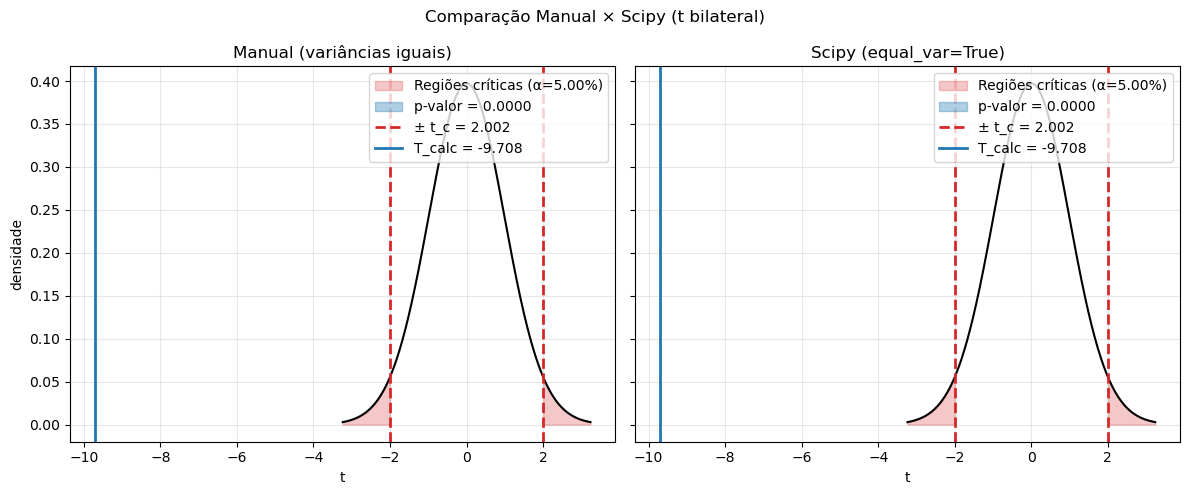

In [57]:
# Gráfico comparativo
try:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # --- Painel: Manual ---
    x_m = np.linspace(stats.t.ppf(0.001, gl), stats.t.ppf(0.999, gl), 1600)
    y_m = stats.t.pdf(x_m, gl)
    ax[0].plot(x_m, y_m, color='black', lw=1.5)

    # Regiões críticas (bilateral)
    mask_c_esq_m = x_m <= -t_crit
    mask_c_dir_m = x_m >= t_crit
    ax[0].fill_between(x_m[mask_c_esq_m], 0, y_m[mask_c_esq_m], color='tab:red', alpha=0.25, label=f'Regiões críticas (α={alpha:.2%})')
    ax[0].fill_between(x_m[mask_c_dir_m], 0, y_m[mask_c_dir_m], color='tab:red', alpha=0.25)

    # p-valor (duas caudas) para |T_calc|
    zabs_m = abs(T_calc)
    mask_p_esq_m = x_m <= -zabs_m
    mask_p_dir_m = x_m >= zabs_m
    ax[0].fill_between(x_m[mask_p_esq_m], 0, y_m[mask_p_esq_m], color='tab:blue', alpha=0.35, label=f'p-valor = {p_valor:.4f}')
    ax[0].fill_between(x_m[mask_p_dir_m], 0, y_m[mask_p_dir_m], color='tab:blue', alpha=0.35)

    ax[0].axvline(-t_crit, color='tab:red', ls='--', lw=2, label=f'± t_c = {t_crit:.3f}')
    ax[0].axvline(t_crit, color='tab:red', ls='--', lw=2)
    ax[0].axvline(T_calc, color='tab:blue', lw=2, label=f'T_calc = {T_calc:.3f}')

    metodo_lbl = 'variâncias iguais' if 'variancias_iguais' in globals() and variancias_iguais else 'variâncias diferentes'
    ax[0].set_title(f'Manual ({metodo_lbl})')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('densidade')
    ax[0].grid(alpha=0.3)
    ax[0].legend(loc='upper right')

    # --- Painel: Scipy ---
    x_s = np.linspace(stats.t.ppf(0.001, gl_scipy_10), stats.t.ppf(0.999, gl_scipy_10), 1600)
    y_s = stats.t.pdf(x_s, gl_scipy_10)
    ax[1].plot(x_s, y_s, color='black', lw=1.5)

    mask_c_esq_s = x_s <= -tcrit_10
    mask_c_dir_s = x_s >= tcrit_10
    ax[1].fill_between(x_s[mask_c_esq_s], 0, y_s[mask_c_esq_s], color='tab:red', alpha=0.25, label=f'Regiões críticas (α={alpha:.2%})')
    ax[1].fill_between(x_s[mask_c_dir_s], 0, y_s[mask_c_dir_s], color='tab:red', alpha=0.25)

    zabs_s = abs(T_scipy_10)
    mask_p_esq_s = x_s <= -zabs_s
    mask_p_dir_s = x_s >= zabs_s
    ax[1].fill_between(x_s[mask_p_esq_s], 0, y_s[mask_p_esq_s], color='tab:blue', alpha=0.35, label=f'p-valor = {p_scipy_10:.4f}')
    ax[1].fill_between(x_s[mask_p_dir_s], 0, y_s[mask_p_dir_s], color='tab:blue', alpha=0.35)

    ax[1].axvline(-tcrit_10, color='tab:red', ls='--', lw=2, label=f'± t_c = {tcrit_10:.3f}')
    ax[1].axvline(tcrit_10, color='tab:red', ls='--', lw=2)
    ax[1].axvline(T_scipy_10, color='tab:blue', lw=2, label=f'T_calc = {T_scipy_10:.3f}')

    ax[1].set_title(f'Scipy (equal_var={equal_var_10})')
    ax[1].set_xlabel('t')
    ax[1].grid(alpha=0.3)
    ax[1].legend(loc='upper right')

    fig.suptitle('Comparação Manual × Scipy (t bilateral)')
    plt.tight_layout()
    plt.show()
except NameError:
    print('Variáveis não definidas.')

### Overlay e barras de métricas

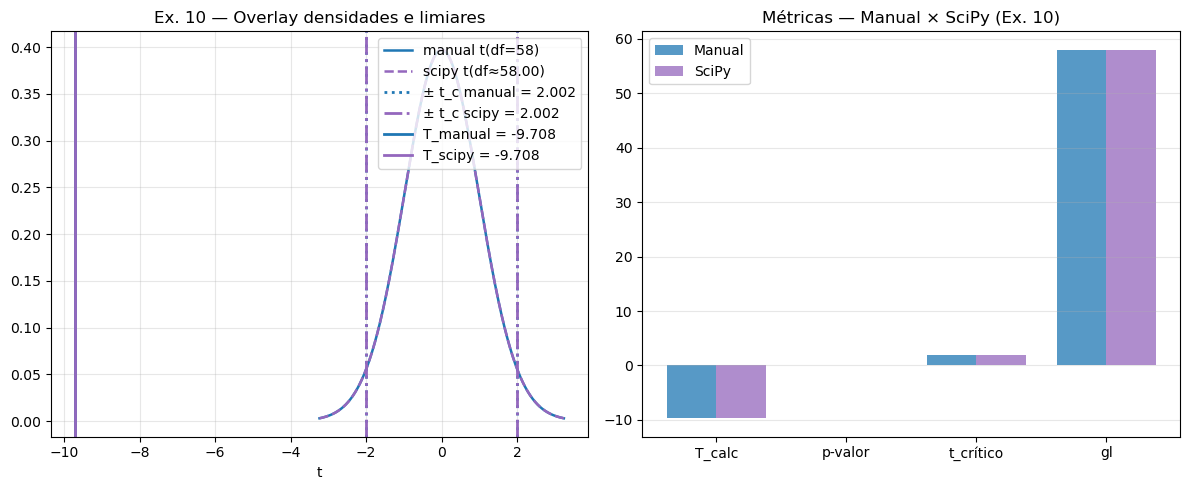

In [59]:
try:
    # Usar gl do manual e gl_scipy_10 do SciPy
    x_m = np.linspace(stats.t.ppf(0.001, gl), stats.t.ppf(0.999, gl), 1600)
    y_m = stats.t.pdf(x_m, gl)

    x_s = np.linspace(stats.t.ppf(0.001, gl_scipy_10), stats.t.ppf(0.999, gl_scipy_10), 1600)
    y_s = stats.t.pdf(x_s, gl_scipy_10)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    # Painel 1: overlay densidades (gl manual vs gl SciPy)
    ax[0].plot(x_m, y_m, color='tab:blue', lw=1.8, label=f'manual t(df={gl})')
    ax[0].plot(x_s, y_s, color='tab:purple', lw=1.8, ls='--', label=f'scipy t(df≈{gl_scipy_10:.2f})')
    ax[0].axvline(-t_crit, color='tab:blue', ls=':', lw=2, label=f'± t_c manual = {t_crit:.3f}')
    ax[0].axvline(t_crit, color='tab:blue', ls=':', lw=2)
    ax[0].axvline(-tcrit_10, color='tab:purple', ls='-.', lw=2, label=f'± t_c scipy = {tcrit_10:.3f}')
    ax[0].axvline(tcrit_10, color='tab:purple', ls='-.', lw=2)
    ax[0].axvline(T_calc, color='tab:blue', lw=2, label=f'T_manual = {T_calc:.3f}')
    ax[0].axvline(T_scipy_10, color='tab:purple', lw=2, label=f'T_scipy = {T_scipy_10:.3f}')
    ax[0].set_title('Ex. 10 — Overlay densidades e limiares')
    ax[0].set_xlabel('t')
    ax[0].grid(alpha=0.3)
    ax[0].legend(loc='upper right')

    # Painel 2: barras — métricas
    categorias = ['T_calc', 'p-valor', 't_crítico', 'gl']
    manual_vals = [T_calc, float(p_valor), float(t_crit), float(gl)]
    scipy_vals = [T_scipy_10, float(p_scipy_10), float(tcrit_10), float(gl_scipy_10)]
    idx = np.arange(len(categorias))
    width = 0.38
    ax[1].bar(idx - width/2, manual_vals, width, color='tab:blue', alpha=0.75, label='Manual')
    ax[1].bar(idx + width/2, scipy_vals, width, color='tab:purple', alpha=0.75, label='SciPy')
    ax[1].set_xticks(idx, categorias)
    ax[1].set_title('Métricas — Manual × SciPy (Ex. 10)')
    ax[1].grid(axis='y', alpha=0.3)
    ax[1].legend()

    plt.tight_layout()
    plt.show()
except NameError:
    print('Execute primeiro as células do Exemplo 10 (manual e SciPy).')